In [18]:
import warnings
import numpy as np
from hmmlearn import hmm
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


# add a warning suppressing
warnings.filterwarnings("ignore")

<h1> Hidden Markov Models </h1><br>Application the GBPEUR Exchange rate overe the last five years
<br>
The data will be downloaded using a spreadsheet (<i>googlefinance client no longer works)  </i><br>
Note that the hmm is no longer part of sklearn (release 0.17). The command <i>pip install hmmlearn</i> is required.

In [19]:
df = pd.read_excel('EURGBP.xlsx',index_col='date')
df.head()

,EURGBP
date,
2007-10-23,0.69575
2007-10-24,0.69550
2007-10-25,0.69765
2007-10-26,0.70100
2007-10-29,0.69895


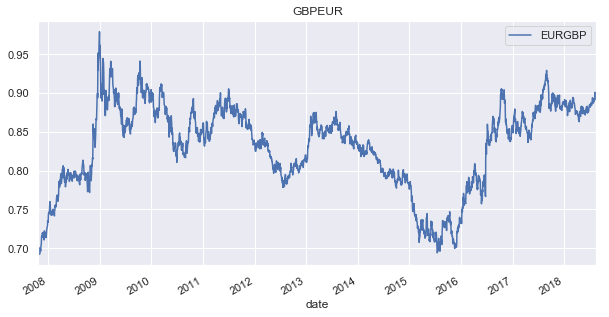

In [20]:
df.plot(figsize=(10,5),title='GBPEUR');

Calculating (log) returns for the dataset

In [21]:
df['Ret']= df['EURGBP'].pct_change(periods=1)
df['LogRet'] = df['Ret'].apply(lambda x: np.log(1+x))
df.dropna(how='any',inplace=True)

We opt for a hidden markov model with <b>3 hidden states </b>. Each state has a <b> Gaussian Emission </b> to visible states. The visible states are the sequence of daily logreturns observed for the GBPEUR Exchange Rate.

In [22]:
X = df['LogRet'].values.reshape(-1,1)
model = hmm.GaussianHMM(n_components=3, covariance_type="full")
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

Fitting the model to the data will reveal information on :
<ol>
<li> The transition matrix "orchestrating" the way that the hidden states move between each other. 
<li> The Emission from each of the hidden states to the visible states takes Gaussian model (mean + variance)
</ol>

In [23]:
print('transition matrix')
pd.DataFrame(model.transmat_)

transition matrix


,0,1,2
0,0.409773,0.192302,0.397925
1,0.381025,0.248369,0.370606
2,0.409661,0.192470,0.397869


In [24]:
print('Means of the Gaussians')
print(model.means_.ravel())
print('Hidden State 0 is producing random normal numbers with mean ',np.round(np.float(model.means_[0]),8))

Means of the Gaussians
[-1.90808052e-05  5.36717612e-04 -3.20945245e-05]
Hidden State 0 is producing random normal numbers with mean  -1.908e-05


In [25]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100)

Standard deviations
[0.56301923 0.94633367 0.56869733]


The first two states generate returns with a very similar standard deviation and it makes sense to group these together.
Both hidden states have also positive returns. <br>
<b>=>Opting for 2 hidden states</b>

In [26]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [27]:
print('transition matrix')
print(pd.DataFrame(model.transmat_))
print('\nWhat do these data tell you ?\nWhat is the most frequent state?')

transition matrix
          0         1
0  0.637793  0.362207
1  0.592691  0.407309

What do these data tell you ?
What is the most frequent state?


In [28]:
print('Means of the Gaussians')
print(model.means_.ravel())

Means of the Gaussians
[-2.48785498e-05  2.75549882e-04]


In [29]:
print('Standard deviations')
print(np.sqrt(model.covars_.ravel())*100)

Standard deviations
[0.50576043 0.80083233]


From the sequence $X$ (= observed log returns), one can derive the corresponding hidden states. This done using the <b>Viterbi</b> algortihm

In [30]:
Z = model.predict(X).reshape(-1,1)

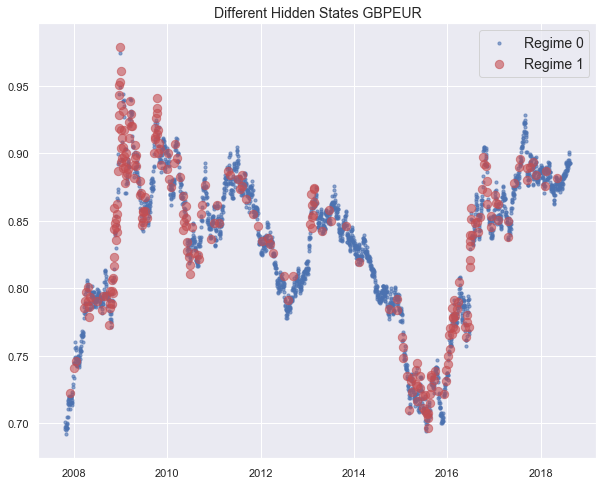

In [31]:
fig = plt.subplots(1,1,figsize=(10,8))
color = ['b','r']
size = [10,70]
for z , c , s , i in zip(np.unique(Z),
                         color,size,
                         np.arange(0,len(model.means_))):
    
    plt.scatter(df[Z==z].index,
                df[Z==z]['EURGBP'],
                c=c,
                s=s,
                alpha=0.6,
               label='Regime '+str(i))
plt.title('Different Hidden States GBPEUR',fontsize=14);
plt.legend(loc=1,fontsize=14);

Can we plot the evolution of the "High Volatility Regime" post / pre Brexit ?
<br>In a rolling window of 250 days, we can count the number of high volatility days<br>

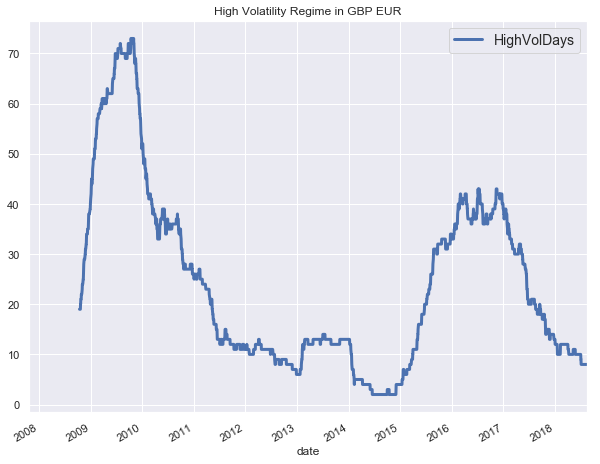

In [32]:
df['Regime']= Z
df['HighVolDays']=df['Regime'].rolling(window=250).apply(lambda x : np.sum(x==1))
df['HighVolDays'].plot(figsize=(10,8),title='High Volatility Regime in GBP EUR',linewidth=3);
plt.legend(fontsize=14);